In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

/kaggle/input/playground-series-s5e3/sample_submission.csv
/kaggle/input/playground-series-s5e3/train.csv
/kaggle/input/playground-series-s5e3/test.csv


# Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import (
    train_test_split, GridSearchCV, StratifiedKFold
)
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation
from catboost import CatBoostClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    f1_score, 
    accuracy_score, 
    roc_curve, 
    roc_auc_score
)
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Binary Prediction with a Rainfall Dataset

Complete initial notebook (Public):

https://www.kaggle.com/code/les1781/rainfall-prediction-playground-series-s5-e3#Binary-Prediction-with-a-Rainfall-Dataset

In [3]:
# We load the data

rainfall_train = pd.read_csv("/kaggle/input/playground-series-s5e3/train.csv", index_col="id")

In [4]:
print("Shape: ", rainfall_train.shape)
rainfall_train.head()

Shape:  (2190, 12)


,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
rainfall_train.describe()

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
count,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,179.948402,1013.602146,26.365799,23.953059,22.170091,20.454566,82.036530,75.721918,3.744429,104.863151,21.804703,0.753425
std,105.203592,5.655366,5.654330,5.222410,5.059120,5.288406,7.800654,18.026498,3.626327,80.002416,9.898659,0.431116
min,1.000000,999.000000,10.400000,7.400000,4.000000,-0.300000,39.000000,2.000000,0.000000,10.000000,4.400000,0.000000
25%,89.000000,1008.600000,21.300000,19.300000,17.700000,16.800000,77.000000,69.000000,0.400000,40.000000,14.125000,1.000000
50%,178.500000,1013.000000,27.800000,25.500000,23.850000,22.150000,82.000000,83.000000,2.400000,70.000000,20.500000,1.000000
75%,270.000000,1017.775000,31.200000,28.400000,26.400000,25.000000,88.000000,88.000000,6.800000,200.000000,27.900000,1.000000
max,365.000000,1034.600000,36.000000,31.500000,29.800000,26.700000,98.000000,100.000000,12.100000,300.000000,59.500000,1.000000


In [6]:
rainfall_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2190 entries, 0 to 2189
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            2190 non-null   int64  
 1   pressure       2190 non-null   float64
 2   maxtemp        2190 non-null   float64
 3   temparature    2190 non-null   float64
 4   mintemp        2190 non-null   float64
 5   dewpoint       2190 non-null   float64
 6   humidity       2190 non-null   float64
 7   cloud          2190 non-null   float64
 8   sunshine       2190 non-null   float64
 9   winddirection  2190 non-null   float64
 10  windspeed      2190 non-null   float64
 11  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(2)
memory usage: 222.4 KB


# Encoding And Scaling

In [7]:
rainfall_end = rainfall_train.drop(["day"], axis=1)

In [8]:
rainfall_end.describe().T

,count,mean,std,min,25%,50%,75%,max
pressure,2190.0,1013.602146,5.655366,999.0,1008.600,1013.00,1017.775,1034.6
maxtemp,2190.0,26.365799,5.654330,10.4,21.300,27.80,31.200,36.0
temparature,2190.0,23.953059,5.222410,7.4,19.300,25.50,28.400,31.5
mintemp,2190.0,22.170091,5.059120,4.0,17.700,23.85,26.400,29.8
dewpoint,2190.0,20.454566,5.288406,-0.3,16.800,22.15,25.000,26.7
humidity,2190.0,82.036530,7.800654,39.0,77.000,82.00,88.000,98.0
cloud,2190.0,75.721918,18.026498,2.0,69.000,83.00,88.000,100.0
sunshine,2190.0,3.744429,3.626327,0.0,0.400,2.40,6.800,12.1
winddirection,2190.0,104.863151,80.002416,10.0,40.000,70.00,200.000,300.0
windspeed,2190.0,21.804703,9.898659,4.4,14.125,20.50,27.900,59.5


In [9]:
rainfall_end.corr().style.background_gradient(cmap="Greens")

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
pressure,1.000000,-0.800499,-0.816531,-0.814453,-0.817008,-0.119949,0.098600,-0.257163,-0.643293,0.266012,-0.049886
maxtemp,-0.800499,1.000000,0.982932,0.965529,0.906703,-0.072615,-0.289047,0.452387,0.662235,-0.354168,-0.079304
temparature,-0.816531,0.982932,1.000000,0.987150,0.933617,-0.025016,-0.249355,0.414019,0.668963,-0.342262,-0.049660
mintemp,-0.814453,0.965529,0.987150,1.000000,0.941342,0.009891,-0.219399,0.379497,0.663828,-0.328871,-0.026841
dewpoint,-0.817008,0.906703,0.933617,0.941342,1.000000,0.153390,-0.088446,0.249676,0.643073,-0.312179,0.081965
humidity,-0.119949,-0.072615,-0.025016,0.009891,0.153390,1.000000,0.584854,-0.541592,-0.012430,0.062285,0.454213
cloud,0.098600,-0.289047,-0.249355,-0.219399,-0.088446,0.584854,1.000000,-0.805128,-0.127087,0.184698,0.641191
sunshine,-0.257163,0.452387,0.414019,0.379497,0.249676,-0.541592,-0.805128,1.000000,0.272235,-0.241752,-0.555287
winddirection,-0.643293,0.662235,0.668963,0.663828,0.643073,-0.012430,-0.127087,0.272235,1.000000,-0.192417,-0.006939
windspeed,0.266012,-0.354168,-0.342262,-0.328871,-0.312179,0.062285,0.184698,-0.241752,-0.192417,1.000000,0.111625


In [10]:
# We separate the target variable from the features

x_rain = rainfall_end.drop(columns="rainfall")
y_rainfall = rainfall_end["rainfall"]

In [11]:
# We transform the data

rs = RobustScaler()

num_va = rs.fit_transform(x_rain)

x_rainfall = pd.DataFrame(
    num_va, columns=rs.get_feature_names_out(x_rain.columns)
)

In [12]:
x_rainfall.describe()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
count,2190.000000,2190.000000,2190.000000,2.190000e+03,2.190000e+03,2190.000000,2190.000000,2190.000000,2190.000000,2190.000000
mean,0.065629,-0.144869,-0.169993,-1.930930e-01,-2.067602e-01,0.003321,-0.383057,0.210067,0.217895,0.094715
std,0.616389,0.571144,0.573891,5.815081e-01,6.449276e-01,0.709150,0.948763,0.566614,0.500015,0.718596
min,-1.525886,-1.757576,-1.989011,-2.281609e+00,-2.737805e+00,-3.909091,-4.263158,-0.375000,-0.375000,-1.168784
25%,-0.479564,-0.656566,-0.681319,-7.068966e-01,-6.524390e-01,-0.454545,-0.736842,-0.312500,-0.187500,-0.462795
50%,0.000000,0.000000,0.000000,-2.046974e-16,2.168404e-16,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.520436,0.343434,0.318681,2.931034e-01,3.475610e-01,0.545455,0.263158,0.687500,0.812500,0.537205
max,2.354223,0.828283,0.659341,6.839080e-01,5.548780e-01,1.454545,0.894737,1.515625,1.437500,2.831216


In [13]:
mi_scores = mutual_info_classif(x_rainfall, y_rainfall)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=x_rainfall.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

cloud            0.211965
sunshine         0.159010
humidity         0.132586
winddirection    0.022701
dewpoint         0.019614
temparature      0.018492
maxtemp          0.016834
mintemp          0.012420
pressure         0.002473
windspeed        0.001615
Name: MI Scores, dtype: float64

In [14]:
x_rainfall = x_rainfall.drop(columns=["maxtemp", "mintemp", "winddirection"])

In [15]:
x_rainfall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pressure     2190 non-null   float64
 1   temparature  2190 non-null   float64
 2   dewpoint     2190 non-null   float64
 3   humidity     2190 non-null   float64
 4   cloud        2190 non-null   float64
 5   sunshine     2190 non-null   float64
 6   windspeed    2190 non-null   float64
dtypes: float64(7)
memory usage: 119.9 KB


# Model Selection

In [16]:
# We separate the data into training and test sets

x_train, x_val, y_train, y_val = (
    train_test_split(
        x_rainfall, y_rainfall, test_size=0.2, random_state=42
    )
)

In [17]:
# We review the balance of the target variable

values_counts = np.asarray(np.unique(y_train, return_counts=True))

print(values_counts)

[[   0    1]
 [ 421 1331]]


In [18]:
def evaluator(model, xtrain, ytrain, xval, yval):

    '''
    We calculate the precision score
    We obtain prediction from the model
    We calculate the f1 score
    Train result and accuracy score test
    Print train and test macro f1 score
    '''

    train_ascore = model.score(xtrain, ytrain)
    val_ascore = model.score(xval, yval)

    y_train_pred = model.predict(xtrain)
    y_val_pred = model.predict(xval)

    train_fscore = f1_score(ytrain, y_train_pred, average="macro")
    val_fscore = f1_score(yval, y_val_pred, average="macro")

    print(f"Train - Accuracy score: {train_ascore}")
    print(f"Test - Accuracy score: {val_ascore}\n")
    print(f"Train - F1-Score: {train_fscore}")
    print(f"Test - F1-Score: {val_fscore}")

In [19]:
def matrix_evaluator(model, xval, yval, list_classes, color_map):
    '''
    We create the confusion matrix
    We plot the confusion matrix
    Report results
    '''
    y_pred = model.predict(xval)
    cm_values = confusion_matrix(yval, y_pred)
    df_cm = pd.DataFrame(
        cm_values,
        columns=list_classes,
        index=list_classes
        )
    df_cm.index.name = "Actual"
    df_cm.columns.name = "Predicted"

    plt.figure(figsize=(6, 4))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap=color_map)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("\n")
    print(classification_report(
        yval, y_pred, target_names=list_classes
    ))

## LogisticRegression

In [20]:
# We create the model instance

lrc = LogisticRegression()

# Train the model with the data

lrc.fit(x_train, y_train)

LogisticRegression()

In [21]:
# We make predictions

prediction_lrc = lrc.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, prediction_lrc),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, prediction_lrc)
     )

Confusion matrix:

 [[ 73  46]
 [ 20 299]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.78      0.61      0.69       119
           1       0.87      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.78      0.79       438
weighted avg       0.84      0.85      0.84       438



In [22]:
# We establish the parameters to test

lrc_hyperparameters = {
    "C": [0.5, 1.0, 1.5],
    "max_iter": [50, 100, 150],
    "penalty": ["l1","l2","elasticnet","none"]
}

lrc_grid = GridSearchCV(
    lrc,
    lrc_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

lrc_search = lrc_grid.fit(x_train, y_train)

print(
    f"Parametros: {lrc_search.best_params_}\nPuntaje: {lrc_search.best_score_}"
)

Parametros: {'C': 0.5, 'max_iter': 50, 'penalty': 'l2'}
Puntaje: 0.8692942612942612


In [23]:
# We evaluate the accuracy and the f1-score

evaluator(lrc_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.8710045662100456
Test - Accuracy score: 0.8493150684931506

Train - F1-Score: 0.8112094170241091
Test - F1-Score: 0.7933075933075933


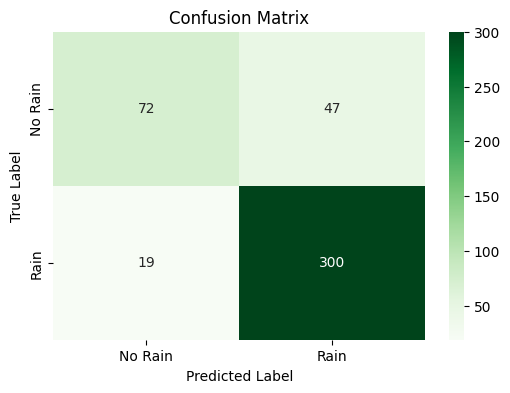



              precision    recall  f1-score   support

     No Rain       0.79      0.61      0.69       119
        Rain       0.86      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.77      0.79       438
weighted avg       0.84      0.85      0.84       438



In [24]:
# We graph the confusion matrix

matrix_evaluator(
    lrc_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

## LabelPropagation

In [25]:
# We create the model instance

label_prop = LabelPropagation()

# Train the model with the data

label_prop.fit(x_train, y_train)

LabelPropagation()

In [26]:
# We make predictions

lp_prediction = label_prop.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, lp_prediction),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, lp_prediction)
     )

Confusion matrix:

 [[ 69  50]
 [ 27 292]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.72      0.58      0.64       119
           1       0.85      0.92      0.88       319

    accuracy                           0.82       438
   macro avg       0.79      0.75      0.76       438
weighted avg       0.82      0.82      0.82       438



In [27]:
# We establish the parameters to test

lp_hyperparameters = {
    "gamma": [10, 20, 30],
    "kernel" : ["knn", "rbf"],
    "max_iter": [500, 1000, 1500],
    "n_neighbors" : [4, 7, 14]
}

lp_grid = GridSearchCV(
    label_prop,
    lp_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

lp_search = lp_grid.fit(x_train, y_train)

print(
    f"Parametros: {lp_search.best_params_}\nPuntaje: {lp_search.best_score_}"
)

Parametros: {'gamma': 10, 'kernel': 'knn', 'max_iter': 500, 'n_neighbors': 14}
Puntaje: 0.8641562881562882


In [28]:
# We evaluate the accuracy and the f1-score

evaluator(lp_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.8818493150684932
Test - Accuracy score: 0.8401826484018264

Train - F1-Score: 0.83337123859224
Test - F1-Score: 0.7821948170038646


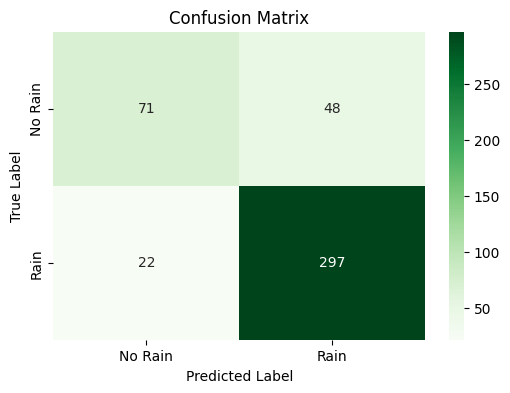



              precision    recall  f1-score   support

     No Rain       0.76      0.60      0.67       119
        Rain       0.86      0.93      0.89       319

    accuracy                           0.84       438
   macro avg       0.81      0.76      0.78       438
weighted avg       0.83      0.84      0.83       438



In [29]:
# We graph the confusion matrix

matrix_evaluator(
    lp_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

## XGBClassifier

In [30]:
# We create the model instance

xgbc = xgb.XGBClassifier()

# Train the model with the data

xgbc.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [31]:
# We make predictions

xgbc_prediction = xgbc.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, xgbc_prediction),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, xgbc_prediction)
     )

Confusion matrix:

 [[ 68  51]
 [ 22 297]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.76      0.57      0.65       119
           1       0.85      0.93      0.89       319

    accuracy                           0.83       438
   macro avg       0.80      0.75      0.77       438
weighted avg       0.83      0.83      0.83       438



In [32]:
# We establish the parameters to test

xgbc_hyperparameters = {
    "n_estimators": [100, 150],
    "max_depth" : [6, 8],
    "gamma" : [0, 1],
    "alpha" : [0, 1],
    "subsample" : [0.5, 1],
    "scale_pos_weight" : [1, 2]
}

xgbc_grid = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search = xgbc_grid.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search.best_params_}\nPuntaje: {xgbc_search.best_score_}"
)

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
Puntaje: 0.8670150590150592


In [33]:
# We evaluate the accuracy and the f1-score

evaluator(xgbc_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9286529680365296
Test - Accuracy score: 0.860730593607306

Train - F1-Score: 0.899553033934104
Test - F1-Score: 0.8119973261091369


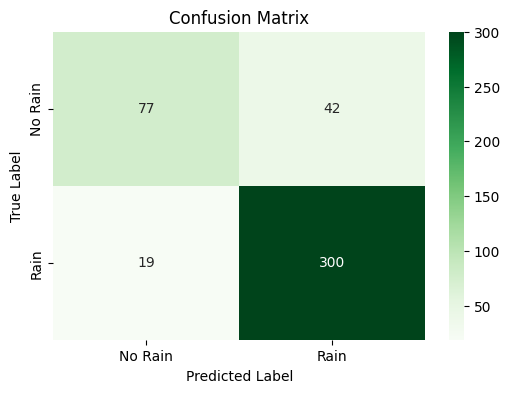



              precision    recall  f1-score   support

     No Rain       0.80      0.65      0.72       119
        Rain       0.88      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.79      0.81       438
weighted avg       0.86      0.86      0.86       438



In [34]:
# We graph the confusion matrix

matrix_evaluator(
    xgbc_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

In [35]:
# We tested a new grid with cv=10

xgbc_grid_two = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=10,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search_two = xgbc_grid_two.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search_two.best_params_}\nPuntaje: {xgbc_search_two.best_score_}"
)

Parametros: {'alpha': 1, 'gamma': 1, 'max_depth': 8, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1}
Puntaje: 0.8664512987012987


In [36]:
# We make predictions

xgbc_prediction_two = xgbc_search_two.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, xgbc_prediction_two),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, xgbc_prediction_two)
     )

Confusion matrix:

 [[ 77  42]
 [ 19 300]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.80      0.65      0.72       119
           1       0.88      0.94      0.91       319

    accuracy                           0.86       438
   macro avg       0.84      0.79      0.81       438
weighted avg       0.86      0.86      0.86       438



## CatBoostClassifier

In [37]:
# We create the model instance

cbc = CatBoostClassifier(silent=True)

# Train the model with the data

cbc.fit(x_train, y_train)

In [38]:
# We make predictions

prediction_cbc = cbc.predict(x_val)
print(
    "Confusion matrix:\n\n", 
    confusion_matrix(y_val, prediction_cbc),
    "\n\nClassification Report:\n\n", 
    classification_report(y_val, prediction_cbc)
     )

Confusion matrix:

 [[ 73  46]
 [ 19 300]] 

Classification Report:

               precision    recall  f1-score   support

           0       0.79      0.61      0.69       119
           1       0.87      0.94      0.90       319

    accuracy                           0.85       438
   macro avg       0.83      0.78      0.80       438
weighted avg       0.85      0.85      0.85       438



In [39]:
# We establish the parameters to test

cbc_hyperparameters = {
    "depth": [4],
    "learning_rate": [0.09],
    #"iterations": [500, 1000],
    "l2_leaf_reg": [9],
    "bagging_temperature": [0.07]
}

cbc_grid = GridSearchCV(
    cbc,
    cbc_hyperparameters,
    cv=5,
    scoring="accuracy",
    return_train_score=True
)

cbc_search = cbc_grid.fit(x_train, y_train)

print(
    f"Parametros: {cbc_search.best_params_}\nPuntaje: {cbc_search.best_score_}"
)

Parametros: {'bagging_temperature': 0.07, 'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.09}
Puntaje: 0.8573072853072853


cbc_hyperparameters = {

    "depth": [4, 6, 8, 10],
    
    "learning_rate": [0.08, 0.09, 0.1, 0.2],
    
    #"iterations": [500, 1000],
    
    "l2_leaf_reg": [1, 3, 6, 9],
    
    "bagging_temperature": [0.07, 0.08, 0.09, 0.1]
    
}

Parametros: {'depth': 4}
Puntaje: 0.8721514041514041

Parametros: {'learning_rate': 0.09}
Puntaje: 0.8567342287342289

Parametros: {'l2_leaf_reg': 9}
Puntaje: 0.8635929995929995

Parametros: {'bagging_temperature': 0.07}
Puntaje: 0.8698705738705739

In [40]:
# We evaluate the accuracy and the f1-score

evaluator(cbc_search, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9834474885844748
Test - Accuracy score: 0.8401826484018264

Train - F1-Score: 0.9768951098560037
Test - F1-Score: 0.779335559649931


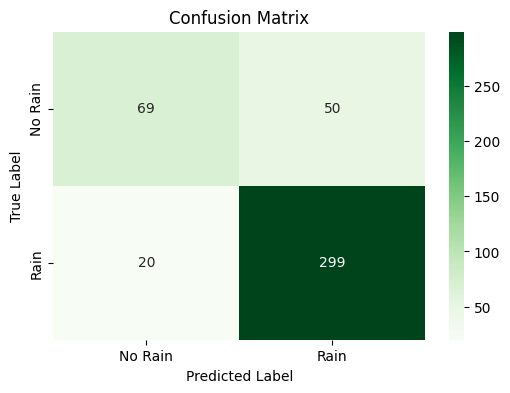



              precision    recall  f1-score   support

     No Rain       0.78      0.58      0.66       119
        Rain       0.86      0.94      0.90       319

    accuracy                           0.84       438
   macro avg       0.82      0.76      0.78       438
weighted avg       0.83      0.84      0.83       438



In [41]:
# We graph the confusion matrix

matrix_evaluator(
    cbc_search, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

In [42]:
# We obtain the accuracy score of the models

y_val_pred_lrc = lrc_search.predict(x_val)
y_val_pred_lp = lp_search.predict(x_val)
y_val_pred_xgbc = xgbc_search.predict(x_val)
y_val_pred_cbc = cbc_search.predict(x_val)

lr_model = accuracy_score(y_val, y_val_pred_lrc)
lp_model = accuracy_score(y_val, y_val_pred_lp)
xgbc_model = accuracy_score(y_val, y_val_pred_xgbc)
cbc_model = accuracy_score(y_val, y_val_pred_cbc)

# We compare the accuracy of the models

print(
    "LogisticRegression accuracy score: {0:0.3f}\n".format(lr_model),
    "\nLabelPropagation accuracy score: {0:0.3f}\n".format(lp_model),
    "\nXGBClassifier accuracy score: {0:0.3f}\n".format(xgbc_model),
    "\nCatBoostClassifier accuracy score: {0:0.3f}\n".format(cbc_model)
)

LogisticRegression accuracy score: 0.849
 
LabelPropagation accuracy score: 0.840
 
XGBClassifier accuracy score: 0.861
 
CatBoostClassifier accuracy score: 0.840



In [43]:
# We are left with the probabilities of the positive class (the probability of 1)

lrc_probs = lrc_search.predict_proba(x_train)
lrc_probs = lrc_probs[:, 1]
lpc_probs = lp_search.predict_proba(x_train)
lpc_probs = lpc_probs[:, 1]
xgbc_probs = xgbc_search.predict_proba(x_train)
xgbc_probs = xgbc_probs[:, 1]
cbc_probs = cbc_search.predict_proba(x_train)
cbc_probs = cbc_probs[:, 1]

# We generate an untrained classifier, which will assign 0 to everything

ns_probs = [0 for _ in range(len(y_train))]

# We calculate the AUC

ns_auc = roc_auc_score(y_train, ns_probs)
lrc_auc = roc_auc_score(y_train, lrc_probs)
lpc_auc = roc_auc_score(y_train, lpc_probs)
xgbc_auc = roc_auc_score(y_train, xgbc_probs)
cbc_auc = roc_auc_score(y_train, cbc_probs)

# We print on screen

print('\nUntrained model: ROC AUC = %.3f' % (ns_auc))
print('\nLogisticRegression: ROC AUC = %.3f' % (lrc_auc))
print('\nLabelPropagation: ROC AUC = %.3f' % (lpc_auc))
print('\nXGBClassifier: ROC AUC = %.3f' % (xgbc_auc))
print('\nCatBoostClassifier: ROC AUC = %.3f' % (cbc_auc))


Untrained model: ROC AUC = 0.500

LogisticRegression: ROC AUC = 0.903

LabelPropagation: ROC AUC = 0.924

XGBClassifier: ROC AUC = 0.969

CatBoostClassifier: ROC AUC = 0.998


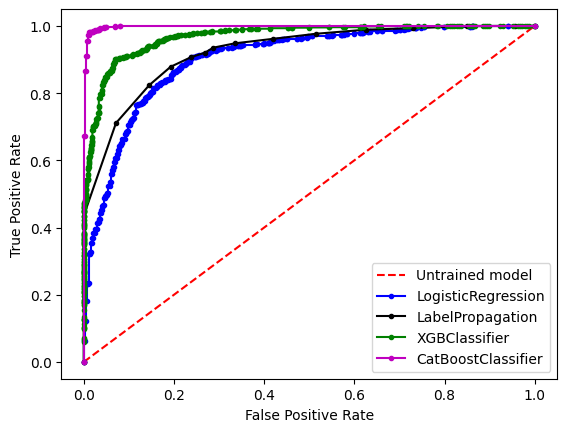

In [44]:
# We calculate the ROC curves

ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
lrc_fpr, lrc_tpr, _ = roc_curve(y_train, lrc_probs)
lpc_fpr, lpc_tpr, _ = roc_curve(y_train, lpc_probs)
xgbc_fpr, xgbc_tpr, _ = roc_curve(y_train, xgbc_probs)
cbc_fpr, cbc_tpr, _ = roc_curve(y_train, cbc_probs)

# We plot the ROC curve

plt.plot(
    ns_fpr, ns_tpr, linestyle="--", color="r", label="Untrained model"
)
plt.plot(
    lrc_fpr, lrc_tpr, marker=".", color="b", label="LogisticRegression"
)
plt.plot(
    lpc_fpr, lpc_tpr, marker=".", color="k", label="LabelPropagation"
)
plt.plot(
    xgbc_fpr, xgbc_tpr, marker=".", color="g", label="XGBClassifier"
)
plt.plot(
    cbc_fpr, cbc_tpr, marker=".", color="m", label="CatBoostClassifier"
)

# We customize the graph

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Modeling

In [45]:
# Create the StratifiedKFold object with 10 divisions (k=10)

s_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [46]:
# Original Values

original_values = np.asarray(np.unique(y_train, return_counts=True))

print(original_values)

[[   0    1]
 [ 421 1331]]


In [47]:
'''
# Aplicamos SMOTE en el conjunto de entrenamiento

smote = SMOTE(k_neighbors=5, random_state=42)

x_train_balance, y_train_balance = smote.fit_resample(x_train, y_train)

# Comprobamos que las clases estan balabceadas

values_counts_smote = np.asarray(np.unique(y_train_balance, return_counts=True))

print(values_counts_smote)
'''

'\n# Aplicamos SMOTE en el conjunto de entrenamiento\n\nsmote = SMOTE(k_neighbors=5, random_state=42)\n\nx_train_balance, y_train_balance = smote.fit_resample(x_train, y_train)\n\n# Comprobamos que las clases estan balabceadas\n\nvalues_counts_smote = np.asarray(np.unique(y_train_balance, return_counts=True))\n\nprint(values_counts_smote)\n'

In [48]:
'''
# Aplicamos RandomOverSampler

ros = RandomOverSampler(random_state=42)

x_train_balance, y_train_balance = ros.fit_resample(x_train, y_train)

# Comprobamos que las clases estan balabceadas

values_counts_ros = np.asarray(np.unique(y_train_balance, return_counts=True))

print(values_counts_ros)
'''

'\n# Aplicamos RandomOverSampler\n\nros = RandomOverSampler(random_state=42)\n\nx_train_balance, y_train_balance = ros.fit_resample(x_train, y_train)\n\n# Comprobamos que las clases estan balabceadas\n\nvalues_counts_ros = np.asarray(np.unique(y_train_balance, return_counts=True))\n\nprint(values_counts_ros)\n'

## XGBClassifier

In [49]:
# We create the model instance

xgbc = xgb.XGBClassifier()

xgbc_hyperparameters = {

    "n_estimators": [100, 150, 200, 250, 300],
    "max_depth" : [3, 4, 6, 8, 10],
    "gamma" : [0, 1, 2, 3, 4, 5],
    "min_child_weight" : [0, 1, 2, 3, 4],
    "subsample" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
    "scale_pos_weight" : [0, 1, 2, 3, 4, 5]
}

In [50]:
# We establish the parameters to test

xgbc_hyperparameters = {
    "n_estimators": [250],
    "max_depth" : [3],
    "gamma" : [4],
    "min_child_weight" : [4],
    "subsample" : [0.6],
    "scale_pos_weight" : [2]
}

# We tested a new grid with StratifiedKFold

xgbc_grid_skf = GridSearchCV(
    xgbc,
    xgbc_hyperparameters,
    cv=s_kfold,
    scoring="accuracy",
    return_train_score=True
)

xgbc_search_skf = xgbc_grid_skf.fit(x_train, y_train)

print(
    f"Parametros: {xgbc_search_skf.best_params_}\nPuntaje: {xgbc_search_skf.best_score_}"
)

Parametros: {'gamma': 4, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 250, 'scale_pos_weight': 2, 'subsample': 0.6}
Puntaje: 0.8550357142857143


Parametros: {'n_estimators': 250} /
Puntaje: 0.8527694805194805

Train - Accuracy score: 1.0 /
Test - Accuracy score: 0.8242009132420092

Train - F1-Score: 1.0 /
Test - F1-Score: 0.7596408081815913

XGBClassifier: ROC AUC = 1.000

Parametros: {'gamma': 4} /
Puntaje: 0.874448051948052

Train - Accuracy score: 0.9006849315068494 /
Test - Accuracy score: 0.8493150684931506

Train - F1-Score: 0.8600567029996768 /
Test - F1-Score: 0.7959454499251772

Parametros: {'max_depth': 3} /
Puntaje: 0.8618961038961039

Train - Accuracy score: 0.946917808219178 /
Test - Accuracy score: 0.8333333333333334

Train - F1-Score: 0.9250074216583553 /
Test - F1-Score: 0.7777777777777777

XGBClassifier: ROC AUC = 0.986

Parametros: {'min_child_weight': 4} /
Puntaje: 0.8590422077922077

Train - Accuracy score: 0.988013698630137 /
Test - Accuracy score: 0.8287671232876712

Train - F1-Score: 0.9833533543723912 /
Test - F1-Score: 0.7673825759989804

XGBClassifier: ROC AUC = 0.999

Parametros: {'subsample': 0.6} /
Puntaje: 0.8578928571428571

Train - Accuracy score: 0.9988584474885844 /
Test - Accuracy score: 0.8127853881278538

Train - F1-Score: 0.9984341484341485 /
Test - F1-Score: 0.7480639730639731

XGBClassifier: ROC AUC = 1.000

suma = sum(negative instances) / sum(positive instances)

Parametros: {'scale_pos_weight': 2} /
Puntaje: 0.8527597402597402

Train - Accuracy score: 0.9988584474885844 /
Test - Accuracy score: 0.8242009132420092

Train - F1-Score: 0.9984341484341485 /
Test - F1-Score: 0.7548180727708917

XGBClassifier: ROC AUC = 1.000

- RandomOverSampler

Parametros: {'n_estimators': 250}
Puntaje: 0.9470403536932219

Parametros: {'max_depth': 10}
Puntaje: 0.9466672298724339

Parametros: {'gamma': 0}
Puntaje: 0.9417856438849934

Parametros: {'min_child_weight': 2}
Puntaje: 0.9417870518994114

Parametros: {'subsample': 0.8}
Puntaje: 0.9459097181155134

Parametros: {'scale_pos_weight': 4}
Puntaje: 0.9507997521894624

In [51]:
# We evaluate the accuracy and the f1-score

evaluator(xgbc_search_skf, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9143835616438356
Test - Accuracy score: 0.8378995433789954

Train - F1-Score: 0.868350392343884
Test - F1-Score: 0.7675141855371067


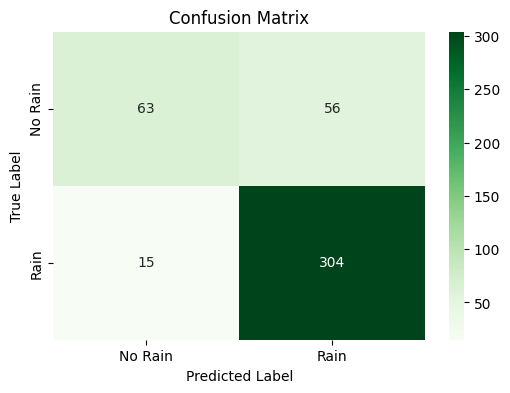



              precision    recall  f1-score   support

     No Rain       0.81      0.53      0.64       119
        Rain       0.84      0.95      0.90       319

    accuracy                           0.84       438
   macro avg       0.83      0.74      0.77       438
weighted avg       0.83      0.84      0.83       438



In [52]:
# We graph the confusion matrix

matrix_evaluator(
    xgbc_search_skf, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

In [53]:
# We calculate the AUC

xgbc_probs = xgbc_search_skf.predict_proba(x_train)
xgbc_probs = xgbc_probs[:, 1]
xgbc_auc = roc_auc_score(y_train, xgbc_probs)
print('\nXGBClassifier: ROC AUC = %.3f' % (xgbc_auc))


XGBClassifier: ROC AUC = 0.957


In [54]:
# We fit the best estimator

xgbc_result = xgbc_search_skf.best_estimator_  
xgbc_result.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=4, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## CatBoostClassifier

In [55]:
# We create the model instance

cbc = CatBoostClassifier(silent=True)

    cbc_hyperparameters = {

        "depth": [4, 6, 8, 10],

        "learning_rate": [0.08, 0.09, 0.1, 0.2],

        "iterations": [500, 1000],

        "l2_leaf_reg": [1, 3, 6, 9],

        "bagging_temperature": [0.07, 0.08, 0.09, 0.1]
    }

In [56]:
# We establish the parameters to test

cbc_hyperparameters = {
    "depth": [4],
    "learning_rate": [0.09],
    "iterations": [1000],
    "l2_leaf_reg": [9],
    "bagging_temperature": [0.07]
}

cbc_grid_skf = GridSearchCV(
    cbc,
    cbc_hyperparameters,
    cv=s_kfold,
    scoring="accuracy",
    return_train_score=True
)

cbc_search_skf = cbc_grid_skf.fit(x_train, y_train)

print(
    f"Parametros: {cbc_search_skf.best_params_}\nPuntaje: {cbc_search_skf.best_score_}"
)

Parametros: {'bagging_temperature': 0.07, 'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 9, 'learning_rate': 0.09}
Puntaje: 0.8607532467532467


Parametros: {'depth': 4} / 
Puntaje: 0.8721558441558441

Parametros: {'learning_rate': 0.1} / 
Puntaje: 0.8618993506493506

Parametros: {'l2_leaf_reg': 6} / 
Puntaje: 0.8681688311688311

Parametros: {'bagging_temperature': 0.07} /
Puntaje: 0.8681590909090909

In [57]:
# We evaluate the accuracy and the f1-score

evaluator(cbc_search_skf, x_train, y_train, x_val, y_val)

Train - Accuracy score: 0.9834474885844748
Test - Accuracy score: 0.8401826484018264

Train - F1-Score: 0.9768951098560037
Test - F1-Score: 0.779335559649931


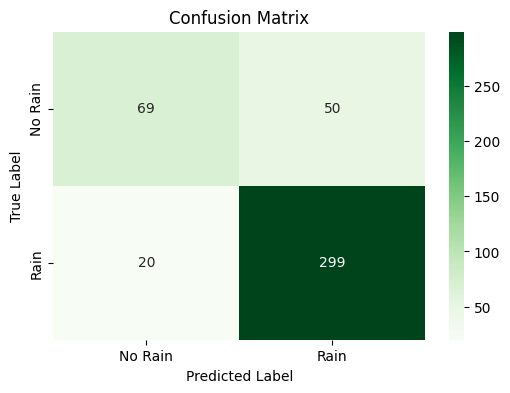



              precision    recall  f1-score   support

     No Rain       0.78      0.58      0.66       119
        Rain       0.86      0.94      0.90       319

    accuracy                           0.84       438
   macro avg       0.82      0.76      0.78       438
weighted avg       0.83      0.84      0.83       438



In [58]:
# We graph the confusion matrix

matrix_evaluator(
    cbc_search_skf, 
    x_val, 
    y_val, 
    ["No Rain", "Rain"], 
    "Greens"
)

In [59]:
# We calculate the AUC

cbc_probs = cbc_search_skf.predict_proba(x_train)
cbc_probs = cbc_probs[:, 1]
cbc_auc = roc_auc_score(y_train, cbc_probs)
print('\nCatBoostClassifier: ROC AUC = %.3f' % (cbc_auc))


CatBoostClassifier: ROC AUC = 0.998


In [60]:
# We fit the best estimator

cbc_result = cbc_search_skf.best_estimator_  
cbc_result.fit(x_train, y_train)

# roc_auc_score and roc_curve

## XGBClassifier & CatBoostClassifier

In [61]:
# We are left with the probabilities of the positive class (the probability of 1)

xgbc_probs = xgbc_result.predict_proba(x_train)
xgbc_probs = xgbc_probs[:, 1]
cbc_probs = cbc_result.predict_proba(x_train)
cbc_probs = cbc_probs[:, 1]

# We generate an untrained classifier, which will assign 0 to everything

ns_probs = [0 for _ in range(len(y_train))]

# We calculate the AUC

ns_auc = roc_auc_score(y_train, ns_probs)
xgbc_auc = roc_auc_score(y_train, xgbc_probs)
cbc_auc = roc_auc_score(y_train, cbc_probs)

# We print on screen

print('\nXGBClassifier: ROC AUC = %.3f' % (xgbc_auc))
print('\nCatBoostClassifier: ROC AUC = %.3f' % (cbc_auc))


XGBClassifier: ROC AUC = 0.957

CatBoostClassifier: ROC AUC = 0.998


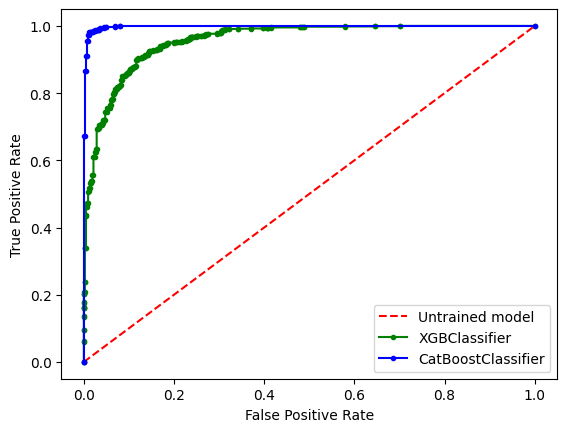

In [62]:
# We calculate the ROC curves

ns_fpr, ns_tpr, _ = roc_curve(y_train, ns_probs)
xgbc_fpr, xgbc_tpr, _ = roc_curve(y_train, xgbc_probs)
cbc_fpr, cbc_tpr, _ = roc_curve(y_train, cbc_probs)

# We plot the ROC curve

plt.plot(
    ns_fpr, ns_tpr, linestyle="--", color="r", label="Untrained model"
)
plt.plot(
    xgbc_fpr, xgbc_tpr, marker=".", color="g", label="XGBClassifier"
)
plt.plot(
    cbc_fpr, cbc_tpr, marker=".", color="b", label="CatBoostClassifier"
)

# We customize the graph

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.show()

# Test data

In [63]:
# We load the test data

df_test = pd.read_csv("/kaggle/input/playground-series-s5e3/test.csv")

# We check the shape and that no duplicate data is found

print(f"Length: {len(df_test.duplicated())}")

print(f"Duplicates: {df_test.duplicated().sum()}")

print(f"Shape: {df_test.shape}")

Length: 730
Duplicates: 0
Shape: (730, 12)


In [64]:
# We start by removing the variables that we will not use

df_test_new = df_test.drop(columns=["id", "day", "maxtemp", "mintemp", "winddirection"])

In [65]:
# We transform the data

num_va_test = rs.fit_transform(df_test_new)

rainfall_test = pd.DataFrame(
    num_va_test, columns=rs.get_feature_names_out(df_test_new.columns)
)

In [66]:
# We apply the trained model

rainfall_predictions = xgbc_result.predict_proba(rainfall_test)

# We review the result

print("Total predictions: ", len(rainfall_predictions), "\n")

Total predictions:  730 



In [67]:
# We create the dataframe

rainfall_submission = pd.DataFrame({
    "id" : df_test["id"], 
    "rainfall" : rainfall_predictions[:, 1]
})

# We review the result

print(
    f"Shape Rainfall Submission: {rainfall_submission.shape}",
    f"\nDataframe Rainfall Submission:\n {rainfall_submission.head(5)}"
)

Shape Rainfall Submission: (730, 2) 
Dataframe Rainfall Submission:
      id  rainfall
0  2190  0.998334
1  2191  0.995355
2  2192  0.967212
3  2193  0.354371
4  2194  0.047262


In [68]:
# We convert the dataframe to a csv file

rainfall_submission.to_csv("submission.csv", index=False)